# CS 445 Final Project: Video/Image Upsamling

### Setup

In [34]:
datadir = "./" 

utilfn = datadir + "utils.py"
imagesfn = datadir + "Images"

In [35]:
import ffmpeg
import cv2
import numpy as np
import os
import numpy.linalg as la
import utils
%matplotlib inline
from matplotlib import pyplot as plt

from random import random
import time
import scipy
import scipy.ndimage as nd
import seaborn as sns
import pandas as pd
import scipy.sparse.linalg
from scipy import optimize
import pwlf

# Image Upsamling

### Read input image

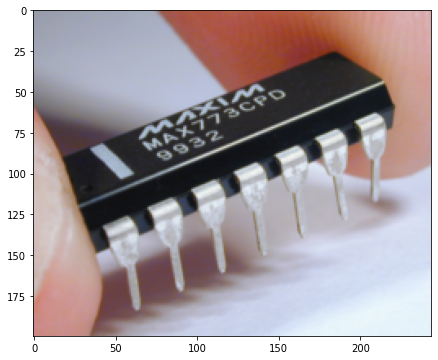

In [36]:
input_img_location = imagesfn + '/chip_input.png'
im1 = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.rcParams["axes.grid"] = False
plt.figure(figsize=(8,6))
plt.imshow(im1)
plt.show()

## 1. Initial Up-Sample using fast bicubic interpolation

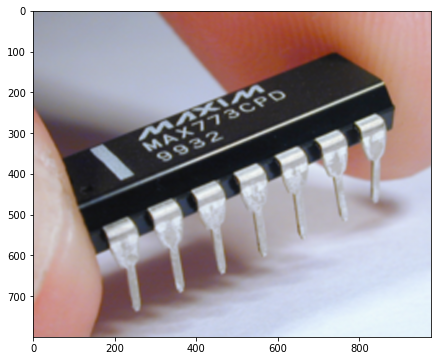

In [37]:
bicubic_im1 = np.clip(cv2.resize(im1, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC),0,1)
plt.figure(figsize=(8, 6))
plt.imshow(bicubic_im1)
plt.show()

## 2. Feedback-control upsamling

## Deconvolution
***
### Compute image gradient density 

Convert the RGB to YUV color space, and then upsample only the Y channel (Y value in range [16-235]). The UV channels are then upsampled to a higher resolution simply by a fast bicubic interpolation:

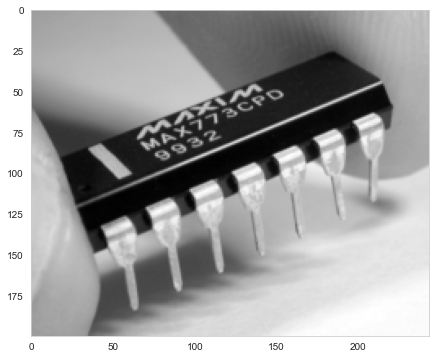

In [15]:
input_img_location = imagesfn + '/chip_input.png'
im1_YUV = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2YUV).astype('double') / 235.0
im1_y, im1_u, im1_v = cv2.split(im1_YUV)
plt.figure(figsize=(8,6))
plt.imshow(im1_y, cmap='gray')
plt.show()

In [38]:
def compute_gradient(img):
    f1 = np.array([[0,-1,0],
                   [0,0,0],
                   [0,1,0]])
    f2 = np.array([[0,0,0],
                   [-1,0,1],
                   [0,0,0]])
    vert_gradient = cv2.filter2D(img, -1, f1)
    horz_gradient = cv2.filter2D(img, -1, f2)
    gradient = np.sqrt(np.square(vert_gradient) + np.square(horz_gradient))
    return gradient

In [39]:
def compute_gradient_xdir(img_y):
    f2 = np.array([[0,0,0],
                   [-1,0,1],
                   [0,0,0]])
    # f2 = np.array([[-1,-2,-1], [0,0,0], [1,2,1]]).T
    horz_gradient = cv2.filter2D(img_y, -1, f2)
    return horz_gradient


def compute_gradient_ydir(img_y):
    f1 = np.array([[0,-1,0],
                   [0,0,0],
                   [0,1,0]])
    # f1 = np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
    vert_gradient = cv2.filter2D(img_y, -1, f1)
    return vert_gradient

In [18]:
gradient_xdir = compute_gradient_xdir(im1_y)
gradient_ydir = compute_gradient_ydir(im1_y)

In [19]:
grad_x_norm = cv2.normalize(gradient_xdir, None, alpha = -235, beta = 235, norm_type = cv2.NORM_MINMAX)
grad_y_norm = cv2.normalize(gradient_ydir, None, alpha = -235, beta = 235, norm_type = cv2.NORM_MINMAX)
grad_x_norm = grad_x_norm.astype(np.int16)
grad_y_norm = grad_y_norm.astype(np.int16)

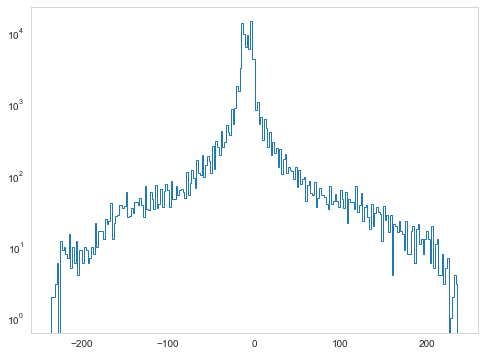

In [20]:
flatten_grad = grad_x_norm.flatten()
flatten_grad = np.append(flatten_grad, grad_y_norm.flatten())
plt.figure(figsize=(8, 6))
counts, bins, bars = plt.hist(flatten_grad, log=True, bins=235,range=(-235,235),facecolor="r", histtype = 'step')
plt.show()

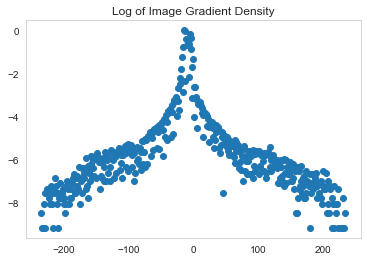

In [36]:
df = pd.Series(flatten_grad).value_counts().reset_index()
df.columns = ['val', 'count']
val = np.array(df['val'])
log_count = np.log(df['count'] / df['count'].max())
plt.scatter(val, log_count)
plt.rcParams["axes.grid"] = True
plt.title("Log of Image Gradient Density")
plt.show()

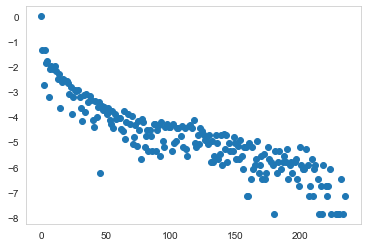

In [40]:
df = pd.Series(flatten_grad).value_counts().reset_index()
df.columns = ['val', 'count']
df = df[df['val'] >= 0]
val = np.array(df['val'])
log_count = np.log(df['count'] / df['count'].max())
plt.rcParams["axes.grid"] = False
plt.scatter(val, log_count)
plt.show()

In [41]:
my_pwlf = pwlf.PiecewiseLinFit(val, log_count)
breaks = my_pwlf.fit(2)
print(breaks)
l_t = breaks[1]
print(l_t)

[  0.          33.99463239 235.        ]
33.9946323890235


In [32]:
def piecewise(x, k, a, b):
    return np.piecewise(x, [x <= l_t, x > l_t], [lambda x: -k*abs(x), lambda x: -1 * (a * (x ** 2) + b)])

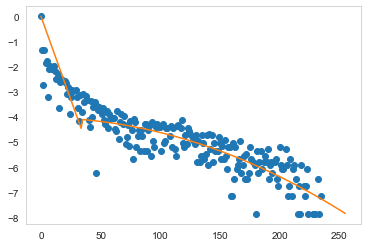

In [43]:
p , e = optimize.curve_fit(piecewise, val, log_count)
xd = np.linspace(0, 255, len(df['count']))
plt.rcParams["axes.grid"] = False
plt.plot(val,  log_count, "o")
plt.plot(xd, piecewise(xd, *p))
plt.show()

In [44]:
k, a, b = p[0], p[1], p[2]
print("k={:.10f}, a={:.10f}, b={:.10f}: ".format(k, a, b))

k=0.1321683441, a=0.0000584524, b=4.0328696468: 


In [40]:
def calculate_phi(gradient_x, gradient_y):
    grad_norm_x = cv2.normalize(gradient_x, None, alpha = -235, beta = 235, norm_type = cv2.NORM_MINMAX)
    grad_norm_y = cv2.normalize(gradient_y, None, alpha = -235, beta = 235, norm_type = cv2.NORM_MINMAX)
    grad_norm_x = grad_norm_x.astype(np.int16)
    grad_norm_y = grad_norm_y.astype(np.int16)
    flattened_grad_x = grad_norm_x.flatten()
    flattened_grad = np.append(flattened_grad_x, grad_norm_y.flatten())
    df = pd.Series(flattened_grad).value_counts().reset_index()
    df.columns = ['val', 'count']
    df = df[df['val'] >= 0]
    val = np.array(df['val'])
    log_count = np.log(df['count'] / df['count'].max())
    my_pwlf = pwlf.PiecewiseLinFit(val, log_count)
    breaks = my_pwlf.fit(2)
    l_t = breaks[1]

    def piecewise(x, k, a, b):
        return np.piecewise(x, [x <= l_t, x > l_t], [lambda x: -k*abs(x), lambda x: -1 * (a * (x ** 2) + b)])

    p , e = optimize.curve_fit(piecewise, val, log_count)
    k, a, b = p[0], p[1], p[2]
    return l_t, k, a, b

In [46]:
l_t, k, a, b = calculate_phi(gradient_xdir, gradient_ydir)
print("k={:.10f}, a={:.10f}, b={:.10f}: ".format(k, a, b))

k=0.1321683441, a=0.0000584524, b=4.0328696468: 


### Minimize Energy function

In [41]:
def generate_full_size_filter(orig_fil, shape):
    full_size_fil = np.zeros(shape)
    x_start = int((full_size_fil.shape[0] - orig_fil.shape[0]) / 2)
    y_start = int((full_size_fil.shape[1] - orig_fil.shape[1]) / 2)
    full_size_fil[x_start:x_start + orig_fil.shape[0], y_start:y_start + orig_fil.shape[1]] = orig_fil
    return full_size_fil

In [48]:
# transform filter to have same size as image version
input_img_location = imagesfn + '/chip_input.png'
im_yuv = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2YUV).astype('double') / 235.0
bicubic_im_yuv = cv2.resize(im_yuv, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC)

### important to make shape odd!!
bicubic_im_yuv = bicubic_im_yuv[:-1,:-1,:]

H_prime_y, _, _ = cv2.split(bicubic_im_yuv)

sigma = 1.5
ksize = int(np.ceil(sigma)*6+1)
fil = cv2.getGaussianKernel(ksize, sigma) # 1D kernel
fil = fil*np.transpose(fil)


fil = generate_full_size_filter(fil, H_prime_y.shape)


In [52]:
H = H_prime_y.copy()  # assume gaussian filter does nothing
H_x_gradient = cv2.filter2D(H, -1, full_f2)
H_y_gradient = cv2.filter2D(H, -1, full_f1)


In [ ]:
## use after pixel substitution
H_prime_y = H_prime_refil.copy()
plt.figure(figsize=(8, 6))
plt.imshow(H_prime_y[200:400, 200:400], cmap='gray')

In [49]:
f_fft = np.fft.fft2(fil)
H_prime_fft = np.fft.fft2(H_prime_y)
H = H_prime_y.copy() 

f1 = np.array([[0,-1,0],
               [0,0,0],
               [0,1,0]])
f2 = np.array([[0,0,0],
               [-1,0,1],
               [0,0,0]])
full_f1 = generate_full_size_filter(f1, H_prime_y.shape)
full_f2 = generate_full_size_filter(f2, H_prime_y.shape)

lambda_1 = 0.3
lambda_2 = 20

H_x_grad_fft = np.fft.fft2(full_f2)
H_y_grad_fft = np.fft.fft2(full_f1)

- $\mu$ Step: fix$H$to optimize $\mu$
$$ E(\mu) = \lambda_1\parallel \Phi(\mu_x) \parallel_1 + \ \lambda_2\parallel \mu_x - \partial_x H \parallel_2^{2}$$
***
$$ \partial_x H \geq l_t : E(\mu) = \lambda_1\parallel -k|\mu_x| \parallel_1 + \lambda_2 \parallel \mu_x - \partial_x H \parallel_2^2$$
***
To:
$$ \partial_x H \leq l_t : E(\mu) = \lambda_1| -k|\mu_x| | + \lambda_2 (\mu_x - \partial_x H)^2$$
***
$$ \partial_x H < l_t : E(\mu) = \lambda_1| -(a \mu_x^2 + b) | + \lambda_2 (\mu_x - \partial_x H)^2$$
***
To
$$ \partial_x H > l_t : E(\mu) = \lambda_1| -(a \mu_x^2 + b) | + \lambda_2 (\mu_x - \partial_x H)^2$$
***
By solving $\partial E(\mu)/ \partial \mu = 0$, we have
$$ \partial H \geq l_t : \mu = \frac{2 \lambda_2 \partial H \pm \lambda_1 k}{2 \lambda_2}$$
***
$$ \partial H < l_t : \mu = \frac{2 \lambda_2 \partial H}{2 \lambda_1 a + 2 \lambda_2}$$

In [42]:
# 𝜇 step
def mu_optimize(l_t, k, a, b, lambda_1, lambda_2, H_x_gradient, H_y_gradient):
    mu_x = np.zeros(H_x_gradient.shape)
    mu_y = np.zeros(H_y_gradient.shape)
    height,width = H_x_gradient.shape[:2]

    # since phi is calculated between 0 and 235
    k = k * 235
    a = a * (235 ** 2)
#     k = k
#     a = a
    for i in range(height):
        for j in range(width):
            curr_x_grad = H_x_gradient[i][j]
            curr_y_grad = H_y_gradient[i][j]

            if abs(curr_x_grad) < l_t:
                if curr_x_grad > 0:
                    mu_x[i][j] = ((2 * lambda_2 * curr_x_grad) - lambda_1 * k) / (2 * lambda_2)
                else:
                    mu_x[i][j] = ((2 * lambda_2 * curr_x_grad) + lambda_1 * k) / (2 * lambda_2)
            else:
                mu_x[i][j] = (2 * lambda_2 * curr_x_grad) / (2 * lambda_1 * a + 2 * lambda_2)

            if abs(curr_y_grad) < l_t:
                if curr_y_grad > 0:
                    mu_y[i][j] = ((2 * lambda_2 * curr_y_grad) - lambda_1 * k) / (2 * lambda_2)
                else:
                    mu_y[i][j] = ((2 * lambda_2 * curr_y_grad) + lambda_1 * k) / (2 * lambda_2)
            else:
                mu_y[i][j] = (2 * lambda_2 * curr_y_grad) / (2 * lambda_1 * a + 2 * lambda_2)

    return mu_x, mu_y


In [53]:
mu_x, mu_y = mu_optimize(l_t, k, a, b, lambda_1, lambda_2, H_x_gradient, H_y_gradient)

In [54]:
(mu_x - H_x_gradient).max()

0.2329467065261602

- $H$ Step: fix$\mu$ to minimize$H$
$$ E(H) = \ \parallel f \otimes H - \tilde{H} \parallel_2^{2} + \ \lambda_2(\parallel \mu_x - \partial_x H \parallel_2^{2} + \parallel \mu_y - \partial_y H \parallel_2^{2}) \ \ \ \ \ \ \ \ \ \ (9)$$
Using Plancherel’s theorem:
$$ E(H) = \ \parallel \mathcal{F}(f) \circ \mathcal{F}(H) - \mathcal{F}(\tilde{H}) \parallel_2^{2} + \ \lambda_2(\parallel \mathcal{F}(\mu_x) - \mathcal{F}(\partial_x) \circ \mathcal{F}(H) \parallel_2^{2} + \parallel \mathcal{F}(\mu_y) - \mathcal{F}(\partial_y) \circ \mathcal{F}(H) \parallel_2^{2}) \ \ \ \ \ \ \ \ \ \ (10)$$

By setting $\partial E(H)/ \partial F(H) = 0$, we obtain an optimal $\mathcal{F}^{*}(H)$ that minimize $E(H)$:

$$
\mathcal{F}^{*}(H) = \frac
{\overline{\mathcal{F}(f)} \circ \mathcal{F}(\tilde{H}) + \lambda_2 \overline{\mathcal{F}(\partial_x)} \circ \mathcal{F}(\mu_x) + \lambda_2 \overline{\mathcal{F}(\partial_y)} \circ \mathcal{F}(\mu_y)}
{\overline{\mathcal{F}(f)} \circ \mathcal{F}(f) + \lambda_2 \overline{\mathcal{F}(\partial_x)} \circ \mathcal{F}(\partial_x) + \lambda_2 \overline{\mathcal{F}(\partial_y)} \circ \mathcal{F}(\partial_y)}
$$

where $\overline{(.)}$ is the conjucate operator and $\mathcal{F}$ is FFT operation.

Finally, $ H^{*} = \mathcal{F}^{-1}(\mathcal{F}^{*}(H)) $

In [43]:
def H_optimize(f_fft, H_prime_fft, lambda_2, H_x_grad_fft, H_y_grad_fft ,mu_x, mu_y):
    mu_x_fft = np.fft.fft2(mu_x)
    mu_y_fft = np.fft.fft2(mu_y)

    upper_adding = lambda_2 * np.conj(H_x_grad_fft) * mu_x_fft + lambda_2 * np.conj(H_y_grad_fft) * mu_y_fft
    lower_adding = lambda_2 * np.conj(H_x_grad_fft) * H_x_grad_fft + lambda_2 * np.conj(H_y_grad_fft) * H_y_grad_fft
#     clip_upper = np.clip(upper_adding, -clip_range, clip_range)
#     clip_lower = np.clip(lower_adding, -clip_range, clip_range)
    clip_upper = upper_adding
    clip_lower = lower_adding

    H_star_fft = ((np.conj(f_fft) * H_prime_fft) +clip_upper) / ((np.conj(f_fft) * f_fft) +clip_lower)
    H_star = np.fft.ifft2(H_star_fft)
    H_star = np.clip(np.real(H_star),0,1)

    shift_result = np.fft.fftshift(H_star,(0,1))
    return shift_result

In [56]:
H_star = H_optimize(f_fft, H_prime_fft, lambda_2, H_x_grad_fft, H_y_grad_fft, mu_x, mu_y)

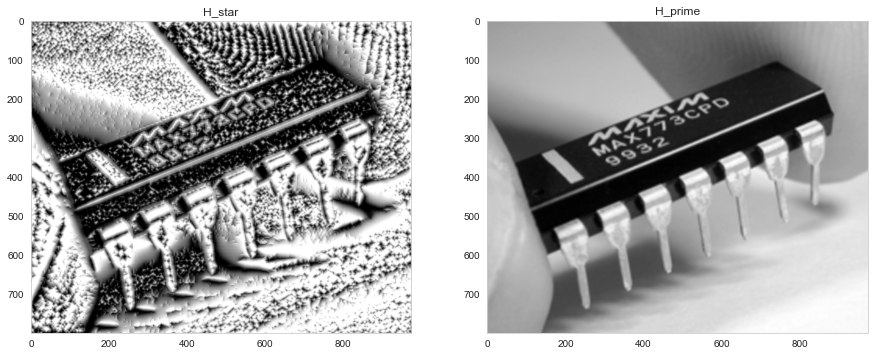

In [57]:
plt.figure(figsize=(15,12))
plt.subplot(1,2,1)
plt.title('H_star')
plt.imshow(H_star, cmap='gray')
plt.subplot(1,2,2)
plt.title('H_prime')
plt.imshow(H_prime_y, cmap='gray')
plt.show()

In [58]:
prev_H_star = H_star
while True:
    lambda_2 *= 3
    mu_x, mu_y = mu_optimize(l_t, k, a, b, lambda_1, lambda_2, H_x_gradient, H_y_gradient)
    H_star = H_optimize(f_fft, H_prime_fft, lambda_2, H_x_grad_fft, H_y_grad_fft, mu_x, mu_y)
    print("1 iteration")
    diff_norm = la.norm(H_star - prev_H_star,2)
    if diff_norm < 0.01:
        break
    else:
        prev_H_star = H_star

1 iteration
1 iteration
1 iteration
1 iteration
1 iteration
1 iteration
1 iteration
1 iteration
1 iteration
1 iteration
1 iteration
1 iteration
1 iteration
1 iteration
1 iteration


In [59]:
H_star = 1 - H_star

In [60]:
H = H_star.copy()  # assume gaussian filter does nothing
H_x_gradient = cv2.filter2D(H, -1, full_f2)
H_y_gradient = cv2.filter2D(H, -1, full_f1)

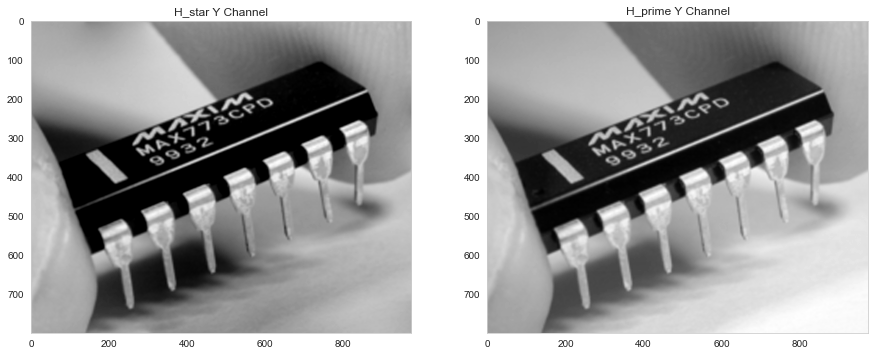

In [61]:
plt.figure(figsize=(15,12))
plt.subplot(1,2,1)
plt.title('H_star Y Channel')
plt.imshow(H_star, cmap='gray')
plt.subplot(1,2,2)
plt.title('H_prime Y Channel')
plt.imshow(H_prime_y, cmap='gray')
plt.show()

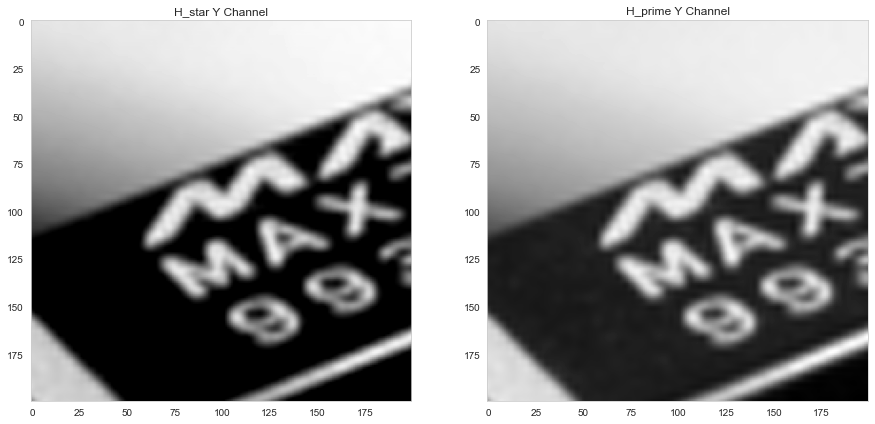

In [62]:
plt.figure(figsize=(15,12))
plt.subplot(1,2,1)
plt.title('H_star Y Channel')
plt.imshow(H_star[200:400, 200:400], cmap='gray')
plt.subplot(1,2,2)
plt.title('H_prime Y Channel')
plt.imshow(H_prime_y[200:400, 200:400], cmap='gray')
plt.show()

#### Show images in RGB

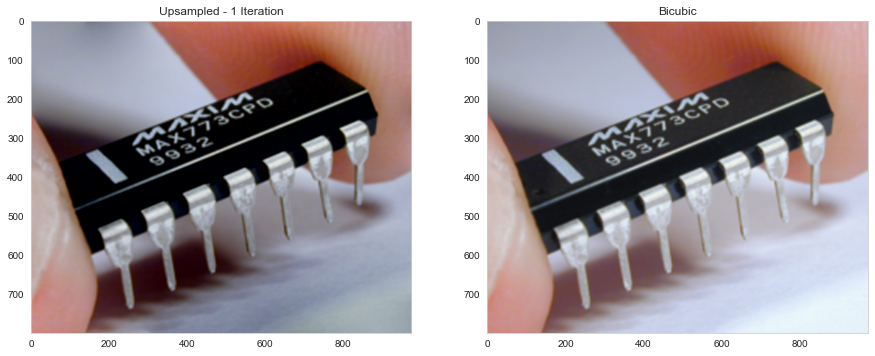

In [63]:
im_rgb = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2RGB).astype('double') / 255.0
bicubic_im_rgb = np.clip(cv2.resize(im_rgb, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC),0,1)
bicubic_im_rgb = bicubic_im_rgb[:-1,:-1,:]

# merge H_star with U and V channels upsampled with bicubic
im_yuv = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2YUV)
bicubic_im_yuv = cv2.resize(im_yuv, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC)
bicubic_im_yuv = bicubic_im_yuv[:-1,:-1,:]
_, bicubic_u, bicubic_v = cv2.split(bicubic_im_yuv)

# normalize H_start to 0-235 from 0-`
H_star_norm = cv2.normalize(H_star, None, alpha = 0, beta = 235, norm_type = cv2.NORM_MINMAX)
H_star_norm = H_star_norm.astype(bicubic_u.dtype)
merged_YUV = cv2.merge([H_star_norm, bicubic_u, bicubic_v])
merged_rgb = cv2.cvtColor(merged_YUV, cv2.COLOR_YUV2RGB)#.astype('double') / 255.0

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title('Upsampled - 1 Iteration')
plt.imshow(merged_rgb)
plt.subplot(1,2,2)
plt.title('Bicubic')
plt.imshow(bicubic_im_rgb)
plt.show()



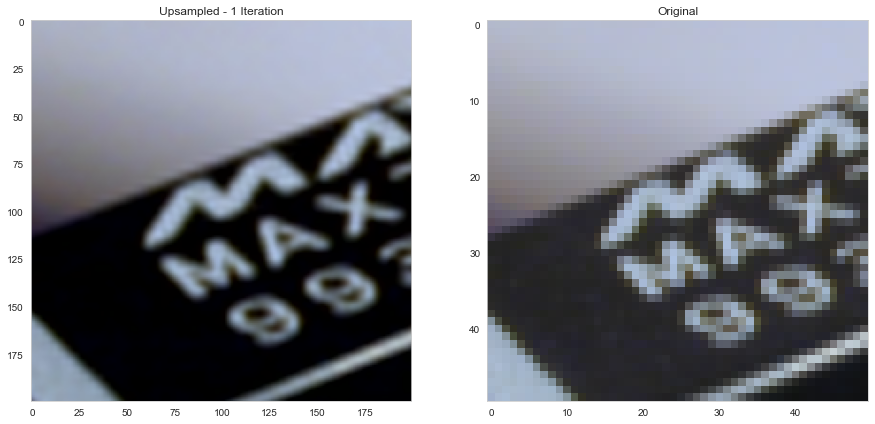

In [64]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title('Upsampled - 1 Iteration')
plt.imshow(merged_rgb[200:400, 200:400])
plt.subplot(1,2,2)
plt.title('Original')
plt.imshow(im1[50:100, 50:100])
plt.show()

## Re-convolution
we need to refine $\tilde{H}$ by reinforcing the information obtained from L

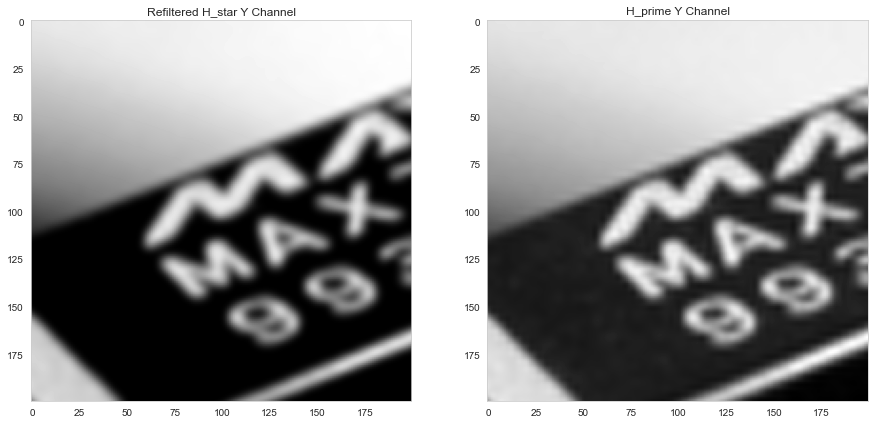

In [65]:
# should be close to bicubic iterpolated image(original h prime)
refil_im = cv2.filter2D(H_star, -1, fil)

plt.figure(figsize=(15,12))
plt.subplot(1,2,1)
plt.title('Refiltered H_star Y Channel')
plt.imshow(refil_im[200:400, 200:400], cmap='gray')
plt.subplot(1,2,2)
plt.title('H_prime Y Channel')
plt.imshow(H_prime_y[200:400, 200:400], cmap='gray')
plt.show()

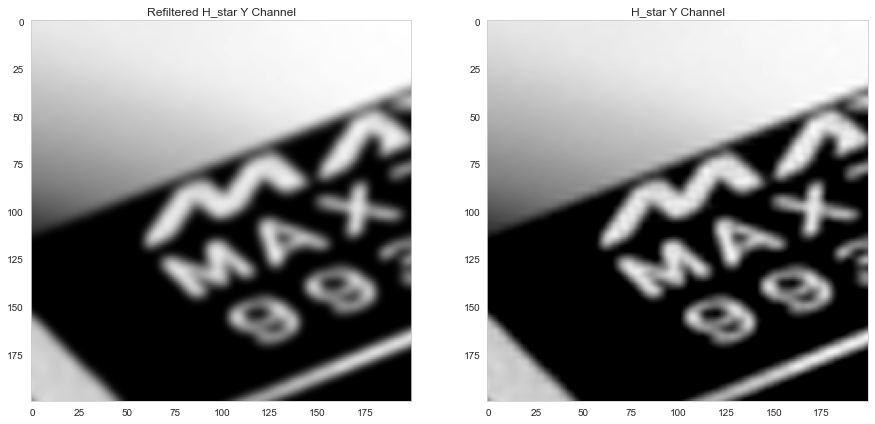

In [66]:
plt.figure(figsize=(15,12))
plt.subplot(1,2,1)
plt.title('Refiltered H_star Y Channel')
plt.imshow(refil_im[200:400, 200:400], cmap='gray')
plt.subplot(1,2,2)
plt.title('H_star Y Channel')
plt.imshow(H_star[200:400, 200:400], cmap='gray')
plt.show()

In [67]:
downsample_refil = cv2.resize(refil_im, None, fx=0.25, fy=0.25)
error_norm = la.norm(downsample_refil - im1_y, 2)

## Pixel Substitution

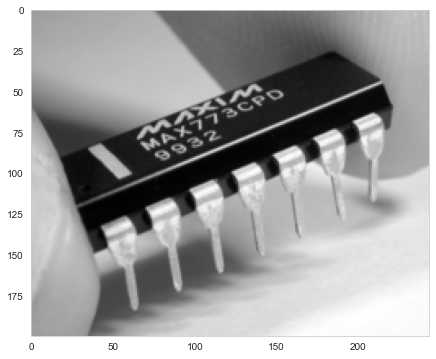

In [68]:
plt.figure(figsize=(8, 6))
plt.imshow(im1_y, cmap='gray')

In [69]:
H_prime_refil = refil_im.copy()

In [70]:
lowest = 10000
highest = 0

n = 4
for i in range(im1_y.shape[0]):
    for j in range(im1_y.shape[1]):
        curr = abs(H_prime_refil[n * i][n * j] - im1_y[i][j])
        if curr < lowest:
            lowest = curr
        if curr > highest:
            highest = curr
print(lowest)
print(highest)

0.0001654296149748713
0.5178139295508003


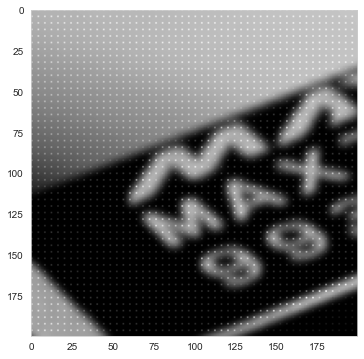

In [71]:
n = 4
for i in range(im1_y.shape[0]):
    for j in range(im1_y.shape[1]):
        H_prime_refil[n * i][n * j] = im1_y[i][j]


plt.figure(figsize=(8, 6))
plt.imshow(H_prime_refil[200:400, 200:400], cmap='gray')

In [ ]:
H_prime_refil.shape

## 3. Final Function

In [64]:
# with mu_skip version
def optimize_loop(H_prime_y, H, l_t, k, a, b, kernel_sigma=1.5, lamda_one=0.3, lamda_two=20):
    f1 = np.array([[0, -1, 0],
                   [0, 0, 0],
                   [0, 1, 0]])
    f2 = np.array([[0, 0, 0],
                   [-1, 0, 1],
                   [0, 0, 0]])

    ksize = int(np.ceil(kernel_sigma) * 6 + 1)
    fil = cv2.getGaussianKernel(ksize, kernel_sigma)  # 1D kernel
    fil = fil * np.transpose(fil)

    fil = generate_full_size_filter(fil, H_prime_y.shape)

    f_fft = np.fft.fft2(fil)
    H_prime_fft = np.fft.fft2(H_prime_y)
    lambda_1 = lamda_one
    lambda_2 = lamda_two

    full_f1 = generate_full_size_filter(f1, H_prime_y.shape)
    full_f2 = generate_full_size_filter(f2, H_prime_y.shape)
    H_x_gradient = cv2.filter2D(H, -1, full_f2)
    H_y_gradient = cv2.filter2D(H, -1, full_f1)
    H_x_grad_fft = np.fft.fft2(full_f2)
    H_y_grad_fft = np.fft.fft2(full_f1)

    H_star_arr = np.zeros((100, H_prime_y.shape[0], H_prime_y.shape[1]), dtype=np.float64)
    
    mu_stop = False
    prev_mu_x = np.zeros(H_x_gradient.shape)
    prev_mu_y = np.zeros(H_y_gradient.shape)
    
    for i in range(100):
        if not mu_stop:
            mu_x, mu_y = mu_optimize(l_t, k, a, b, lambda_1, lambda_2, H_x_gradient, H_y_gradient)
            x_diff = (mu_x - prev_mu_x).max()
            y_diff = (mu_y - prev_mu_y).max()
            if x_diff < 0.001 and y_diff < 0.001:
                mu_stop = True
            prev_mu_x = mu_x
            prev_mu_y = mu_y
        H_star = H_optimize(f_fft, H_prime_fft, lambda_2, H_x_grad_fft, H_y_grad_fft, mu_x, mu_y)
        H_star_arr[i] = 1 - H_star
        lambda_2 *= 3
        if i >= 1:
            diff_norm = la.norm(H_star_arr[i] - H_star_arr[i - 1], 2)
            if diff_norm < 0.01:
                break
    H_star = (1 - H_star)
    return H_star, H_star_arr

In [72]:
# def optimize_loop(H_prime_y, H, l_t,k,a,b,kernel_sigma=1.5,lamda_one=0.3,lamda_two=20):
#     f1 = np.array([[0,-1,0],
#                    [0,0,0],
#                    [0,1,0]])
#     f2 = np.array([[0,0,0],
#                    [-1,0,1],
#                    [0,0,0]])
    
#     ksize = int(np.ceil(kernel_sigma)*6+1)
#     fil = cv2.getGaussianKernel(ksize, kernel_sigma) # 1D kernel
#     fil = fil*np.transpose(fil)

#     fil = generate_full_size_filter(fil, H_prime_y.shape)
    
#     f_fft = np.fft.fft2(fil)
#     H_prime_fft = np.fft.fft2(H_prime_y)
#     lambda_1 = lamda_one
#     lambda_2 = lamda_two

#     full_f1 = generate_full_size_filter(f1, H_prime_y.shape)
#     full_f2 = generate_full_size_filter(f2, H_prime_y.shape)
#     H_x_gradient = cv2.filter2D(H, -1, full_f2)
#     H_y_gradient = cv2.filter2D(H, -1, full_f1)
#     H_x_grad_fft = np.fft.fft2(full_f2)
#     H_y_grad_fft = np.fft.fft2(full_f1)
    
#     H_star_arr = np.zeros((100, H_prime_y.shape[0],H_prime_y.shape[1]), dtype=np.float64)
    
#     for i in range(100):
#         mu_x, mu_y = mu_optimize(l_t, k, a, b, lambda_1, lambda_2, H_x_gradient, H_y_gradient)
#         H_star = H_optimize(f_fft, H_prime_fft, lambda_2, H_x_grad_fft, H_y_grad_fft, mu_x, mu_y)
#         H_star_arr[i] = 1 - H_star
#         lambda_2 *= 3
#         if i >= 1:
#             diff_norm = la.norm(H_star_arr[i] - H_star_arr[i-1],2)
#             if diff_norm < 0.01:
#                 break   
#     H_star = (1 - H_star)
#     return H_star, H_star_arr
    

In [59]:
def pixel_substitute(H_star,orig_im_y,upsample_ratio,kernel_sigma,diff_range=1):
    
    ksize = int(np.ceil(kernel_sigma)*6+1)
    fil = cv2.getGaussianKernel(ksize, kernel_sigma)
    fil = fil*np.transpose(fil)
    H_prime_refil = cv2.filter2D(H_star, -1, fil)
    
    n = upsample_ratio
    for i in range(orig_im_y.shape[0]):
        for j in range(orig_im_y.shape[1]):
            curr = abs(H_prime_refil[n * i][n * j] - orig_im_y[i][j])
            if curr < diff_range:
                H_prime_refil[n * i][n * j] = orig_im_y[i][j]
    
    return H_prime_refil

In [60]:
def upsample_one_image(input_img_location,upsample_ratio=4.0,feedback_loop=2,kernel_sigma=1.5,lamda_one=0.3,lamda_two=20,substitute_diff=0.1):
    im_YUV = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2YUV)
    im_yuv = im_YUV.astype('double') / 235.0
    im_y, im_u, im_v = cv2.split(im_yuv)
    
    gradient_xdir = compute_gradient_xdir(im_y)
    gradient_ydir = compute_gradient_ydir(im_y)
    
    l_t, k, a, b = calculate_phi(gradient_xdir, gradient_ydir)
    
    bicubic_im_yuv = cv2.resize(im_YUV, None, fx=upsample_ratio, fy=upsample_ratio, interpolation=cv2.INTER_CUBIC)
    
    if bicubic_im_yuv.shape[0] % 2 == 0:
        bicubic_im_yuv = bicubic_im_yuv[:-1,:,:]
    if bicubic_im_yuv.shape[1] % 2 == 0:
        bicubic_im_yuv = bicubic_im_yuv[:,:-1,:]
        
    H_prime_y, H_prime_u, H_prime_v = cv2.split(bicubic_im_yuv)
    
    H_prime_y = H_prime_y.astype('double') / 235.0
    H = H_prime_y.copy()
    
    for i in range(feedback_loop):
        H_star, H_star_arr = optimize_loop(H_prime_y,H,l_t,k,a,b,kernel_sigma,lamda_one,lamda_two)
        H = H_star.copy()
        H_prime_y = pixel_substitute(H_star,im_y,int(upsample_ratio),kernel_sigma,substitute_diff)
        print("one iteration finished")
    
    H_star_norm = cv2.normalize(H_star, None, alpha = 0, beta = 235, norm_type = cv2.NORM_MINMAX)
    H_star_norm = H_star_norm.astype(H_prime_u.dtype)
    merged_YUV = cv2.merge([H_star_norm, H_prime_u, H_prime_v])
    merged_rgb = cv2.cvtColor(merged_YUV, cv2.COLOR_YUV2RGB)
    
    return merged_rgb, H_star 

# Video Upsamling

# Analysis

## First example

In [1201]:
input_img_location = imagesfn + '/chip_input.png'
im1_YUV = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2YUV).astype('double') / 235.0
im1_y, im1_u, im1_v = cv2.split(im1_YUV)

In [1202]:
first_iteration_result,first_H_star = upsample_one_image(input_img_location, feedback_loop=1,substitute_diff=0.3)

one iteration finished


Text(0.5, 1.0, 'Bicubic')

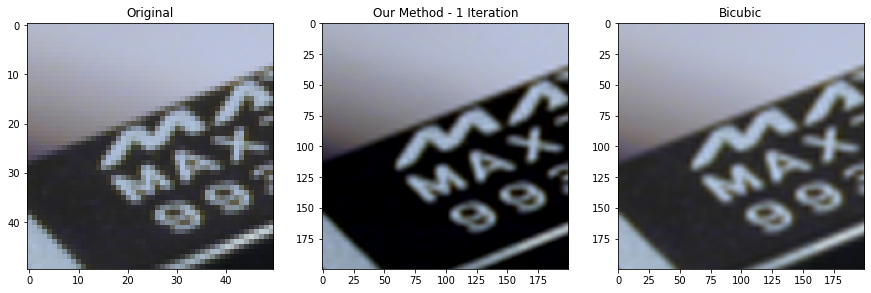

In [1203]:
fig, axs = plt.subplots(1, 3,figsize=(15,12))
axs[0].imshow(im1[50:100, 50:100])
axs[0].set_title('Original')
axs[1].imshow(first_iteration_result[200:400, 200:400])
axs[1].set_title('Our Method - 1 Iteration')
axs[2].imshow(bicubic_im_rgb[200:400, 200:400])
axs[2].set_title('Bicubic')

In [1204]:
# first error with original img
refil_im = cv2.filter2D(first_H_star, -1, fil)
downsample_refil = cv2.resize(refil_im, None, fx=0.25, fy=0.25)
first_error_chip = la.norm(downsample_refil - im1_y, 2)
first_error_chip

53.951385425566386

In [1205]:
second_iteration_result,second_H_star = upsample_one_image(input_img_location, feedback_loop=2,substitute_diff=1)

one iteration finished
one iteration finished


Text(0.5, 1.0, 'Bicubic')

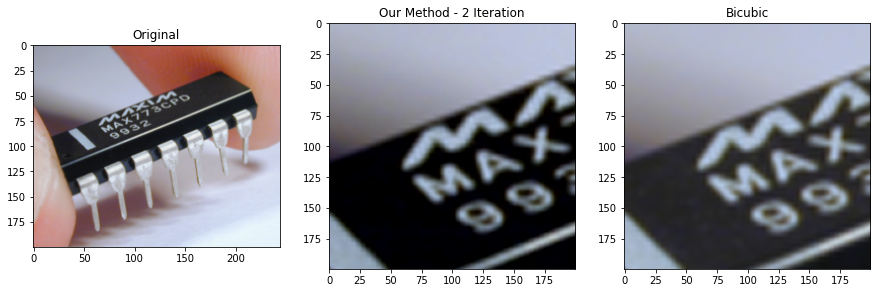

In [1206]:
fig, axs = plt.subplots(1, 3,figsize=(15,12))
axs[0].imshow(im1)
axs[0].set_title('Original')
axs[1].imshow(second_iteration_result[200:400, 200:400])
axs[1].set_title('Our Method - 2 Iteration')
axs[2].imshow(bicubic_im_rgb[200:400, 200:400])
axs[2].set_title('Bicubic')

In [1207]:
# second error with original img
refil_im = cv2.filter2D(second_H_star, -1, fil)
downsample_refil = cv2.resize(refil_im, None, fx=0.25, fy=0.25)
second_error_chip = la.norm(downsample_refil - im1_y, 2)
second_error_chip

21.39873576460398

In [1208]:
forth_iteration_result = upsample_one_image(input_img_location, feedback_loop=4,substitute_diff=0.3)

one iteration finished
one iteration finished
one iteration finished
one iteration finished


Text(0.5, 1.0, 'Bicubic')

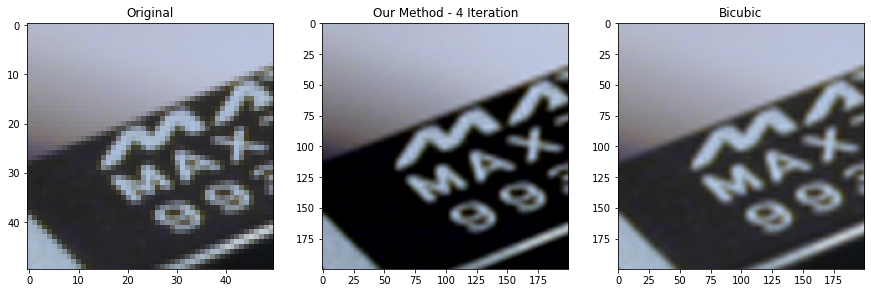

In [1209]:
fig, axs = plt.subplots(1, 3,figsize=(15,12))
axs[0].imshow(im1[50:100, 50:100])
axs[0].set_title('Original')
axs[1].imshow(forth_iteration_result[0][200:400, 200:400])
axs[1].set_title('Our Method - 4 Iteration')
axs[2].imshow(bicubic_im_rgb[200:400, 200:400])
axs[2].set_title('Bicubic')

In [1210]:
# Fourth error with original img
fourth_H_star = forth_iteration_result[1]
refil_im = cv2.filter2D(fourth_H_star, -1, fil)
downsample_refil = cv2.resize(refil_im, None, fx=0.25, fy=0.25)
fourth_error_chip = la.norm(downsample_refil - im1_y, 2)
fourth_error_chip

21.46436170112594

## Another example

In [1211]:
# Another example 
input_img_location = imagesfn + '/input/input_example2.jpg'
im1_YUV = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2YUV).astype('double') / 235.0
im1_y, im1_u, im1_v = cv2.split(im1_YUV)

In [1212]:
input_img = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2RGB).astype('double') / 255.0

In [1213]:
bicubic_input_img = np.clip(cv2.resize(input_img, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC),0,1)

In [1214]:
first_iteration_result = upsample_one_image(input_img_location, feedback_loop=1, substitute_diff=1)

one iteration finished


Text(0.5, 1.0, 'Bicubic')

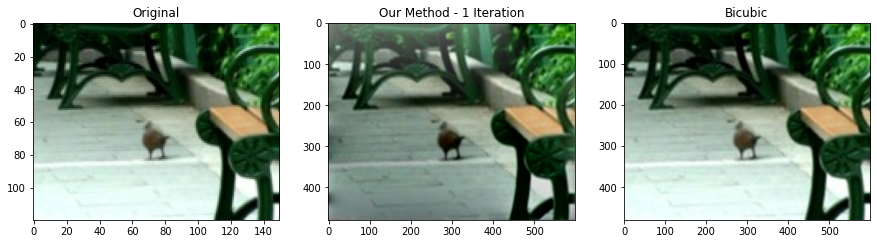

In [1215]:
fig, axs = plt.subplots(1, 3,figsize=(15,12))
axs[0].imshow(input_img)
axs[0].set_title('Original')
axs[1].imshow(first_iteration_result[0])
axs[1].set_title('Our Method - 1 Iteration')
axs[2].imshow(bicubic_input_img)
axs[2].set_title('Bicubic')

In [1216]:
# first error with original img
refil_im = cv2.filter2D(first_iteration_result[1], -1, fil)
downsample_refil = cv2.resize(refil_im, None, fx=0.25, fy=0.25)
first_error_bird = la.norm(downsample_refil - im1_y, 2)
first_error_bird

33.70435923592398

In [1217]:
second_iteration_result = upsample_one_image(input_img_location, feedback_loop=2,substitute_diff=1)

one iteration finished
one iteration finished


Text(0.5, 1.0, 'Bicubic')

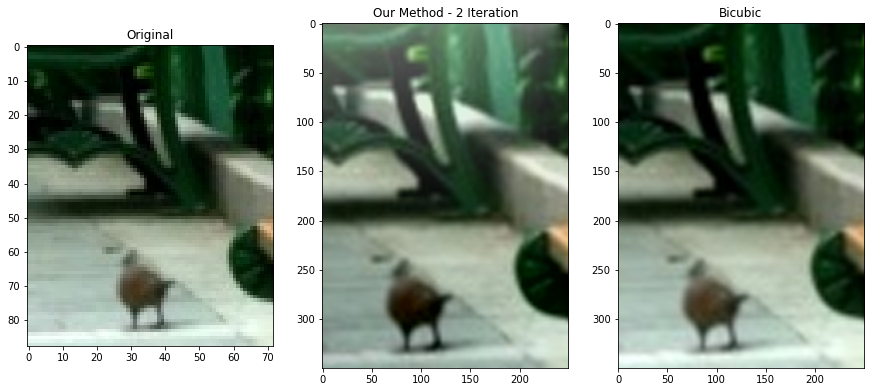

In [1218]:
fig, axs = plt.subplots(1, 3,figsize=(15,12))
axs[0].imshow(input_img[0:88, 40:112])
axs[0].set_title('Original')
axs[1].imshow(second_iteration_result[0][:350,200:450])
axs[1].set_title('Our Method - 2 Iteration')
axs[2].imshow(bicubic_input_img[:350,200:450])
axs[2].set_title('Bicubic')

In [1220]:
# second error with original img
refil_im = cv2.filter2D(second_iteration_result[1], -1, fil)
downsample_refil = cv2.resize(refil_im, None, fx=0.25, fy=0.25)
second_error_bird = la.norm(downsample_refil - im1_y, 2)
second_error_bird

31.65622856144011

In [1221]:
forth_iteration_result = upsample_one_image(input_img_location, feedback_loop=4,substitute_diff=0.3)

one iteration finished
one iteration finished
one iteration finished
one iteration finished


Text(0.5, 1.0, 'Bicubic')

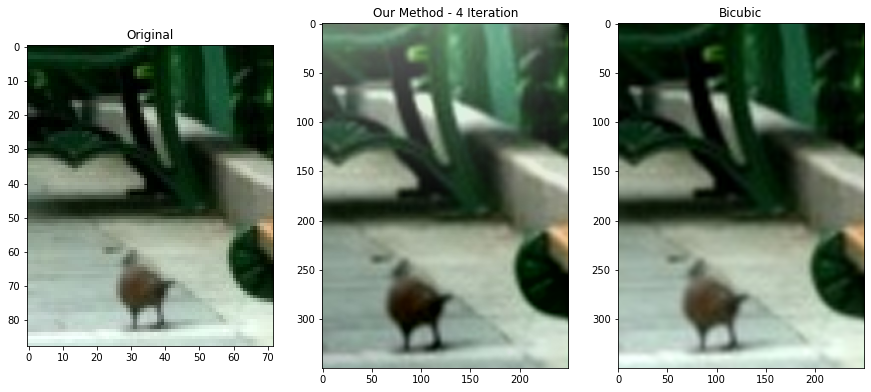

In [1222]:
fig, axs = plt.subplots(1, 3,figsize=(15,12))
axs[0].imshow(input_img[0:88, 40:112])
axs[0].set_title('Original')
axs[1].imshow(forth_iteration_result[0][:350,200:450])
axs[1].set_title('Our Method - 4 Iteration')
axs[2].imshow(bicubic_input_img[:350,200:450])
axs[2].set_title('Bicubic')

In [1223]:
# Fourth error with original img
refil_im = cv2.filter2D(forth_iteration_result[1], -1, fil)
downsample_refil = cv2.resize(refil_im, None, fx=0.25, fy=0.25)
fourth_error_bird = la.norm(downsample_refil - im1_y, 2)
fourth_error_bird

31.619917835017613

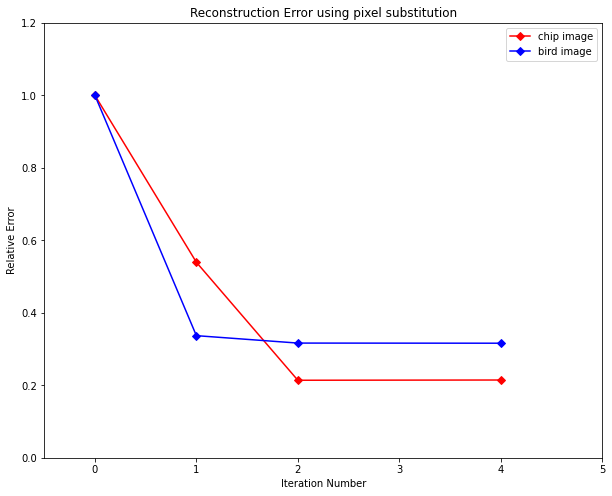

In [1225]:
chip_ys = np.array([100,first_error_chip, second_error_chip, fourth_error_chip])
chip_ys /= 100 
bird_ys = np.array([100,first_error_bird, second_error_bird, fourth_error_bird])
bird_ys /= 100
plt.figure(figsize=(10, 8))
plt.plot([0,1,2,4], chip_ys, '-rD',label='chip image')
plt.plot([0,1,2,4], bird_ys, '-bD',label='bird image')
plt.axis([-0.5, 5, 0, 1.2])
plt.xlabel('Iteration Number')
plt.ylabel('Relative Error')
plt.title('Reconstruction Error using pixel substitution')
plt.legend()
plt.show()

## Deconvolution convergence visual result

In [1226]:

input_img_location = imagesfn + '/chip_input.png'
im_yuv = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2YUV).astype('double') / 235.0
bicubic_im_yuv = cv2.resize(im_yuv, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC)
bicubic_im_yuv = bicubic_im_yuv[:-1,:-1,:]

H_prime_y, _, _ = cv2.split(bicubic_im_yuv)

im1_y, im1_u, im1_v = cv2.split(im_yuv)
gradient_xdir = compute_gradient_xdir(im1_y)
gradient_ydir = compute_gradient_ydir(im1_y)
l_t, k, a, b = calculate_phi(gradient_xdir, gradient_ydir)

In [1229]:
H_star, H_star_arr = optimize_loop(H_prime_y,H_prime_y,l_t,k,a,b,kernel_sigma=1.5,lamda_one=0.3,lamda_two=20)

Text(0.5, 1.0, '6th H-opt')

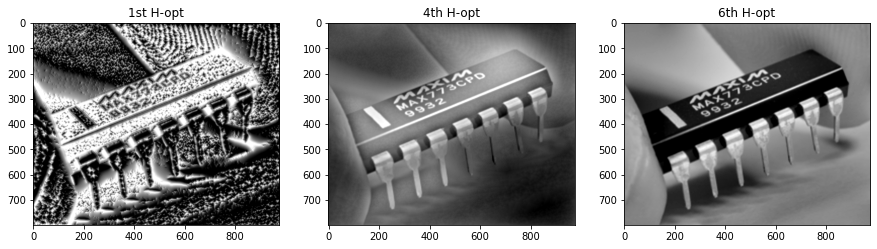

In [1230]:
fig, axs = plt.subplots(1, 3,figsize=(15,12))
axs[0].imshow(H_star_arr[0],cmap="gray")
axs[0].set_title('1st H-opt')
axs[1].imshow(H_star_arr[3],cmap="gray")
axs[1].set_title('4th H-opt')
axs[2].imshow(H_star_arr[6],cmap="gray")
axs[2].set_title('6th H-opt')

# Drawback and Comparison with other method

In [1231]:
from math import log10, sqrt
def PSNR(original, deconvolution):
    mse = np.mean((original - deconvolution) ** 2)
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr


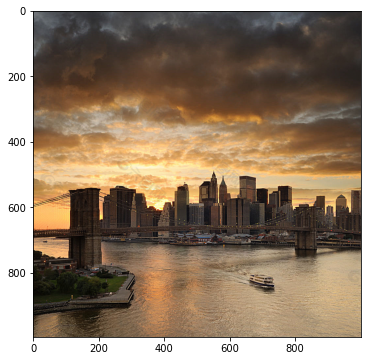

In [1232]:
## test if method works using kernel we give
ground_truth_location = imagesfn + '/input/city.jpeg'
ground_truth_img = cv2.cvtColor(cv2.imread(ground_truth_location), cv2.COLOR_BGR2RGB).astype('double') / 255.0
ground_truth_img = ground_truth_img[:-2,:,:]

plt.figure(figsize=(8, 6))
plt.imshow(ground_truth_img)

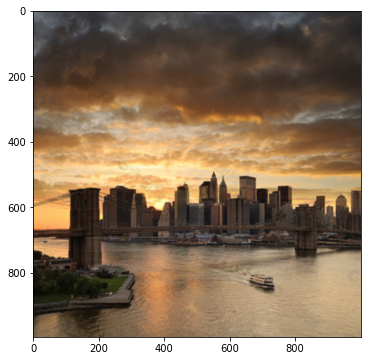

In [1233]:
# blur and down sample expect image using known kernal

sigma = 1.5
ksize = int(np.ceil(sigma)*5+1)
fil = cv2.getGaussianKernel(ksize, sigma) # 1D kernel
fil = fil*np.transpose(fil)

blured_img = cv2.filter2D(ground_truth_img, -1, fil)

plt.figure(figsize=(8, 6))
plt.imshow(blured_img)

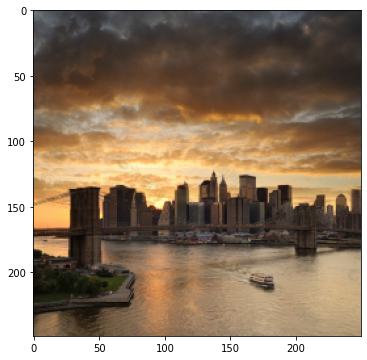

In [1234]:
down_sample_result = cv2.resize(blured_img, None, fx=0.25, fy=0.25)
plt.figure(figsize=(8, 6))
plt.imshow(down_sample_result)

In [1235]:
plt.imsave(imagesfn + '/input/down_sampled_city.jpeg', down_sample_result)

In [1236]:
#upsample using our method
input_img_location = imagesfn + '/input/down_sampled_city.jpeg'
first_iteration_result = upsample_one_image(input_img_location, feedback_loop=1)

one iteration finished


In [1237]:
input_img = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2RGB).astype('double') / 255.0
bicubic_input_img = np.clip(cv2.resize(input_img, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC),0,1)

Text(0.5, 1.0, 'Our result')

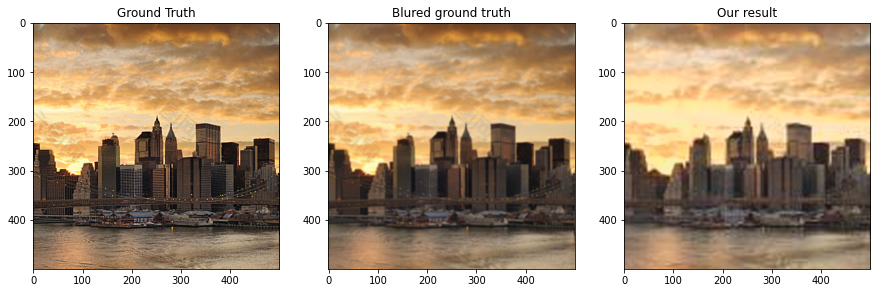

In [1238]:
fig, axs = plt.subplots(1, 3,figsize=(15,12))
axs[0].imshow(ground_truth_img[300:800,300:800])
axs[0].set_title('Ground Truth')
axs[1].imshow(blured_img[300:800,300:800])
axs[1].set_title('Blured ground truth')
axs[2].imshow(first_iteration_result[0][300:800,300:800])
axs[2].set_title('Our result')

Text(0.5, 1.0, 'Bicubic')

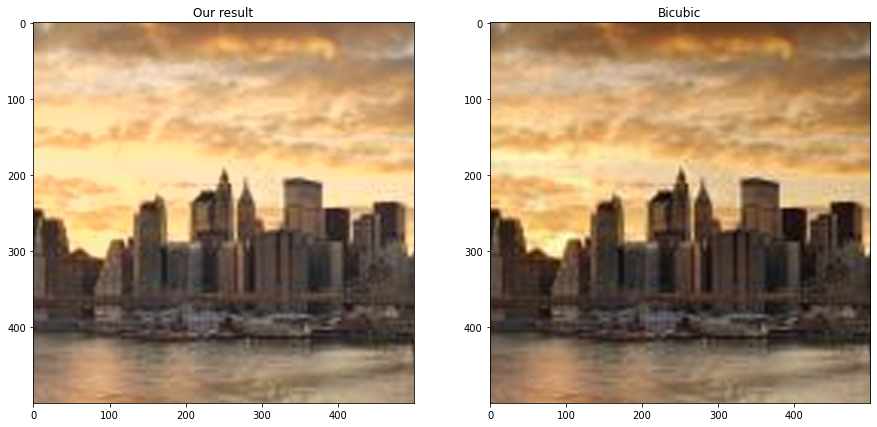

In [1239]:
fig, axs = plt.subplots(1, 2,figsize=(15,12))
axs[0].imshow(first_iteration_result[0][300:800,300:800])
axs[0].set_title('Our result')
axs[1].imshow(bicubic_input_img[300:800,300:800])
axs[1].set_title('Bicubic')

In [1240]:
# PSNR of our method
PSNR(ground_truth_img[:-1,:-1,:],first_iteration_result[0])

5.726261353574555

In [1241]:
# PSNR of bicubic method
PSNR(ground_truth_img,bicubic_input_img)

73.35897398073108

In [1242]:
second_iteration_result = upsample_one_image(input_img_location, feedback_loop=2,substitute_diff=0.5)

one iteration finished
one iteration finished


Text(0.5, 1.0, 'Second Iteration result')

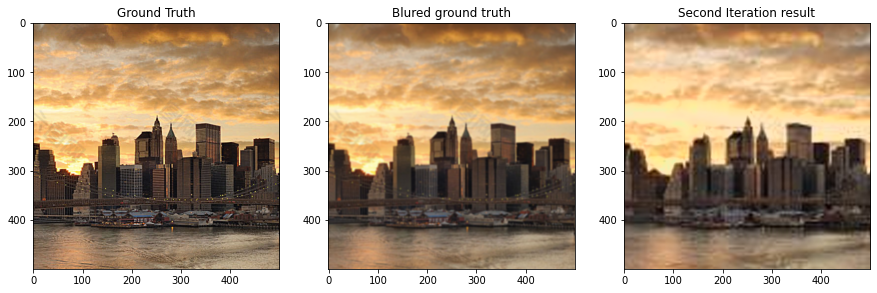

In [1243]:
fig, axs = plt.subplots(1, 3,figsize=(15,12))
axs[0].imshow(ground_truth_img[300:800,300:800])
axs[0].set_title('Ground Truth')
axs[1].imshow(blured_img[300:800,300:800])
axs[1].set_title('Blured ground truth')
axs[2].imshow(second_iteration_result[0][300:800,300:800])
axs[2].set_title('Second Iteration result')

In [1244]:
PSNR(ground_truth_img[:-1,:-1,:],second_iteration_result[0])

6.158797275666648

## Add that perfect deblur method using known kernel here